<a href="https://colab.research.google.com/github/mayarachew/compscience_papers/blob/master/compscience_papers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports


In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import re, string
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 

import plotly.graph_objects as go
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import MDS


Function to plot Confusion Matrix

In [242]:
def plotConfusionMatrix(classifier, X_test, y_test, y_pred, class_names):
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [('Confusion matrix, without normalization', None),('Normalized confusion matrix', 'true')]

    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    return;

Function to create classifier

In [243]:
def createClassifier(classifier, x_train, y_train, x_test, y_test):
    # Create a classifier using train data
    classifier.fit(x_train, y_train)

    # Predict labels using test data
    y_true, y_pred = y_test, classifier.predict(x_test)

    # Print a text report showing the main classification metrics
    print('Classification report: ')
    print(classification_report(y_true, y_pred))

    # Print Confusion Matrix
    print('Confusion matrix: ')
    print(confusion_matrix(y_true, y_pred))
    return y_pred;

Functions to Plot Figure

In [244]:

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def formatColor(color):
    return 'rgb('+str(int(color[0]*255))+','+str(int(color[1]*255))+','+str(int(color[2]*255))+')'
    
def plotFigure(data, labels):
    # Define unique colors to each label
    numColors = len(np.unique(labels))
    cmap = get_cmap(numColors+1)
    colorList = [cmap(i) for i in range(1, numColors+1)]

    traceArr = []
    mapPoints = []
    labelArray = np.unique(labels)

    for lab, col in zip(labelArray, colorList):
        # Plot each point
        mapPoints.extend(np.where(labels==lab))

        trace = go.Scatter(
            x=data[labels==lab, 0],
            y=data[labels==lab, 1],
            mode='markers',
            name = str(lab),
            marker=dict(
                size=8,
                color=formatColor(col),
                opacity=0.8
            ),
        )

        traceArr.append(trace)

    # Create figure
    fig = go.FigureWidget(data=traceArr, layout=go.Layout(
            margin=dict(l=0, r=0, b=0, t=0)
        ))
     
    return fig

Read txt file of the computer science papers set


In [245]:
# Define path to file
path_papers_set = 'data/compscience_papers.csv'

# Read file 
corpus_papers = pd.read_csv(path_papers_set, encoding='utf8')

# Print (rows, columns)
print(corpus_papers.shape)

# Print head of data
print(corpus_papers.head())

# Print first paper
# print(corpus_papers.text[0])

# Find labels (columns)
labels = corpus_papers['label'].unique()

# Print labels
print('Labels:', labels) 

(682, 2)
                                                text  label
0  Digital Image Similarity for Geo-spatial Knowl...      1
1  An Initial Experiment into Stereochemistry-Bas...      2
2  Collaborative Case-Based Recommender Systems\n...      1
3  Knowledge Engineering for CBR systems from a C...      1
4  Analyses for Elucidating Current Question Answ...      3
Labels: [1 2 3 4 5]


Preprocessing


In [246]:
# Convert to lower case
texts = corpus_papers.text
new_texts = [text.lower() for text in texts]

# Strip all punctuation
table = str.maketrans('', '', string.punctuation)
new_texts = [text.translate(table) for text in new_texts]

# Convert all numbers to the word 'num'
new_texts = [re.sub(r'\d+', 'num', text) for text in new_texts]

# Convert text to tokens
nltk.download('punkt')
new_texts = [nltk.word_tokenize(text) for text in new_texts]

# Remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words("english")) 
new_texts = [[word for word in text if word not in stop_words] for text in new_texts]

# Stemming
new_texts = [[LancasterStemmer().stem(word) for word in text] for text in new_texts]

# Lemmatizing
nltk.download('wordnet')
new_texts = [[WordNetLemmatizer().lemmatize(word, 'n') for word in text] for text in new_texts]

# Convert token back to text
new_texts = [TreebankWordDetokenizer().detokenize(text) for text in new_texts]

corpus_papers.text = new_texts
print(corpus_papers.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
                                                text  label
0  digit im simil geosp knowledg man jam carswell...      1
1  init expery stereochemistrybas drug design u i...      2
2  collab casebas recommend system stefano aguzzo...      1
3  knowledg engin cbr system cognit sci perspect ...      1
4  analys elucid cur quest answ technolog marc li...      3


Convert data into matrix

In [247]:
# Convert data into a matrix of TF-IDF features
vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english', max_df=0.95, min_df=4)
tfidf = vectorizer.fit_transform(corpus_papers['text'])

# Print matrix (rows, columns)
print(tfidf.shape)

(682, 4891)


Split dataset into training and test sets

In [248]:
x = tfidf;
y = corpus_papers['label'];

# Split matrix into random train and test subsets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)

Classification by means of Support Vector Machine

Classification report: 
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       110
           2       1.00      0.98      0.99        53
           3       0.99      0.97      0.98        71
           4       0.97      0.97      0.97        37
           5       1.00      1.00      1.00         2

    accuracy                           0.99       273
   macro avg       0.99      0.99      0.99       273
weighted avg       0.99      0.99      0.99       273

Confusion matrix: 
[[110   0   0   0   0]
 [  1  52   0   0   0]
 [  1   0  69   1   0]
 [  0   0   1  36   0]
 [  0   0   0   0   2]]
Confusion matrix, without normalization
[[110   0   0   0   0]
 [  1  52   0   0   0]
 [  1   0  69   1   0]
 [  0   0   1  36   0]
 [  0   0   0   0   2]]
Normalized confusion matrix
[[110   0   0   0   0]
 [  1  52   0   0   0]
 [  1   0  69   1   0]
 [  0   0   1  36   0]
 [  0   0   0   0   2]]


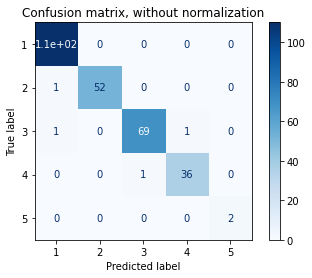

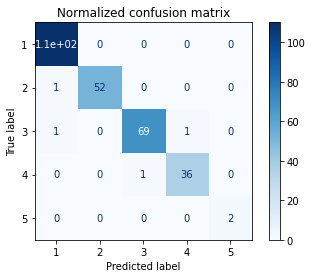

In [249]:
# Define a Support Vector Machine classifier 
svm_clf = SVC(kernel='linear', gamma=0.25, C=1000)

# Create classifier
y_pred = createClassifier(svm_clf, x_train, y_train, x_test, y_test)

# Plot Confusion Matrix
plotConfusionMatrix(svm_clf, x_test, y_test, y_pred, labels)

Classification by means of Artificial Neural Network: Feed-forward Backpropagation Multilayer Perceptron

Classification report: 
              precision    recall  f1-score   support

           1       0.97      1.00      0.99       110
           2       1.00      0.98      0.99        53
           3       0.97      0.93      0.95        71
           4       0.90      0.95      0.92        37
           5       1.00      0.50      0.67         2

    accuracy                           0.97       273
   macro avg       0.97      0.87      0.90       273
weighted avg       0.97      0.97      0.97       273

Confusion matrix: 
[[110   0   0   0   0]
 [  1  52   0   0   0]
 [  2   0  66   3   0]
 [  0   0   2  35   0]
 [  0   0   0   1   1]]
Confusion matrix, without normalization
[[110   0   0   0   0]
 [  1  52   0   0   0]
 [  2   0  66   3   0]
 [  0   0   2  35   0]
 [  0   0   0   1   1]]
Normalized confusion matrix
[[110   0   0   0   0]
 [  1  52   0   0   0]
 [  2   0  66   3   0]
 [  0   0   2  35   0]
 [  0   0   0   1   1]]


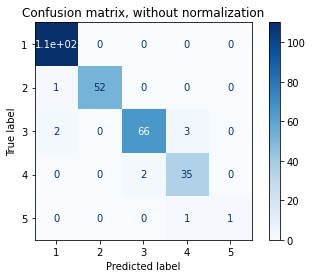

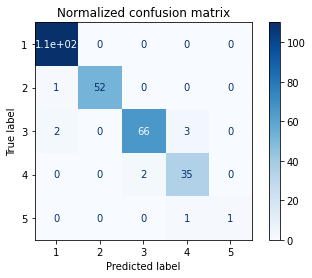

In [250]:
# Define a Multilayer Perceptron classifier 
mlp_clf = MLPClassifier(hidden_layer_sizes=10, max_iter=3000)

# Create classifier
y_pred = createClassifier(mlp_clf, x_train, y_train, x_test, y_test)

# Plot Confusion Matrix
plotConfusionMatrix(mlp_clf, x_test, y_test, y_pred, labels)

Classification by Naive Bayes

Classification report: 
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       110
           2       1.00      0.98      0.99        53
           3       0.99      0.94      0.96        71
           4       0.92      0.97      0.95        37
           5       1.00      1.00      1.00         2

    accuracy                           0.98       273
   macro avg       0.98      0.98      0.98       273
weighted avg       0.98      0.98      0.98       273

Confusion matrix: 
[[110   0   0   0   0]
 [  1  52   0   0   0]
 [  1   0  67   3   0]
 [  0   0   1  36   0]
 [  0   0   0   0   2]]
Confusion matrix, without normalization
[[110   0   0   0   0]
 [  1  52   0   0   0]
 [  1   0  67   3   0]
 [  0   0   1  36   0]
 [  0   0   0   0   2]]
Normalized confusion matrix
[[110   0   0   0   0]
 [  1  52   0   0   0]
 [  1   0  67   3   0]
 [  0   0   1  36   0]
 [  0   0   0   0   2]]


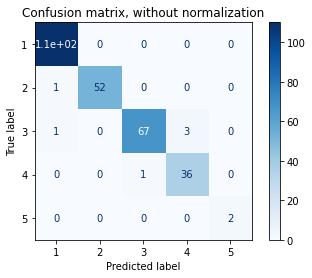

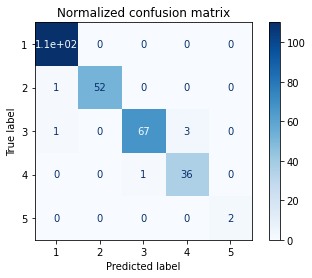

In [251]:
# Define a Naive Bayes classifier
nb_clf = MultinomialNB(alpha=0.01)

# Create classifier
y_pred = createClassifier(nb_clf, x_train, y_train, x_test, y_test)

# Plot Confusion Matrix
plotConfusionMatrix(nb_clf, x_test, y_test, y_pred, labels)


Classification by Random Forest

Classification report: 
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       110
           2       1.00      0.94      0.97        53
           3       0.96      0.96      0.96        71
           4       0.90      0.95      0.92        37
           5       1.00      0.50      0.67         2

    accuracy                           0.97       273
   macro avg       0.97      0.87      0.90       273
weighted avg       0.97      0.97      0.97       273

Confusion matrix: 
[[110   0   0   0   0]
 [  1  50   1   1   0]
 [  1   0  68   2   0]
 [  0   0   2  35   0]
 [  0   0   0   1   1]]
Confusion matrix, without normalization
[[110   0   0   0   0]
 [  1  50   1   1   0]
 [  1   0  68   2   0]
 [  0   0   2  35   0]
 [  0   0   0   1   1]]
Normalized confusion matrix
[[110   0   0   0   0]
 [  1  50   1   1   0]
 [  1   0  68   2   0]
 [  0   0   2  35   0]
 [  0   0   0   1   1]]


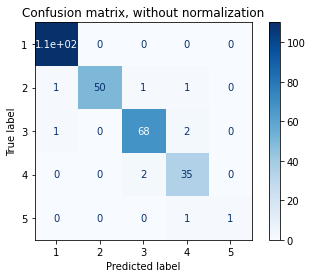

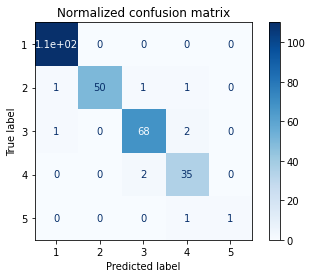

In [252]:
# Define a Random Forest classifier
rf_clf = RandomForestClassifier(n_jobs=-1, max_features='sqrt', n_estimators=50)

# Create classifier
y_pred = createClassifier(rf_clf, x_train, y_train, x_test, y_test)

# Plot Confusion Matrix
plotConfusionMatrix(rf_clf, x_test, y_test, y_pred, labels)


Nearest Neighbors Classifier

Classification report: 
              precision    recall  f1-score   support

           1       0.99      1.00      1.00       110
           2       0.98      0.98      0.98        53
           3       0.96      0.99      0.97        71
           4       0.97      0.89      0.93        37
           5       1.00      1.00      1.00         2

    accuracy                           0.98       273
   macro avg       0.98      0.97      0.98       273
weighted avg       0.98      0.98      0.98       273

Confusion matrix: 
[[110   0   0   0   0]
 [  1  52   0   0   0]
 [  0   0  70   1   0]
 [  0   1   3  33   0]
 [  0   0   0   0   2]]
Confusion matrix, without normalization
[[110   0   0   0   0]
 [  1  52   0   0   0]
 [  0   0  70   1   0]
 [  0   1   3  33   0]
 [  0   0   0   0   2]]
Normalized confusion matrix
[[110   0   0   0   0]
 [  1  52   0   0   0]
 [  0   0  70   1   0]
 [  0   1   3  33   0]
 [  0   0   0   0   2]]


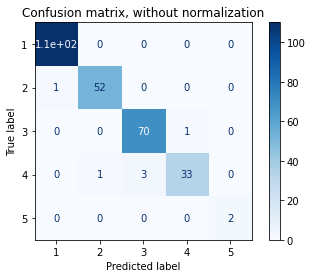

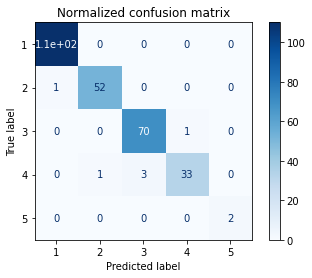

In [253]:
# Define a K-Nearest Neighbors classifier
knn_clf = KNeighborsClassifier(n_neighbors=3) 

# Create classifier
y_pred = createClassifier(knn_clf, x_train, y_train, x_test, y_test)

# Plot Confusion Matrix
plotConfusionMatrix(knn_clf, x_test, y_test, y_pred, labels)

Classification by Decision Tree

Classification report: 
              precision    recall  f1-score   support

           1       1.00      0.96      0.98       110
           2       0.98      0.92      0.95        53
           3       0.90      0.86      0.88        71
           4       0.77      0.97      0.86        37
           5       1.00      1.00      1.00         2

    accuracy                           0.93       273
   macro avg       0.93      0.94      0.93       273
weighted avg       0.94      0.93      0.93       273

Confusion matrix: 
[[106   1   3   0   0]
 [  0  49   3   1   0]
 [  0   0  61  10   0]
 [  0   0   1  36   0]
 [  0   0   0   0   2]]
Confusion matrix, without normalization
[[106   1   3   0   0]
 [  0  49   3   1   0]
 [  0   0  61  10   0]
 [  0   0   1  36   0]
 [  0   0   0   0   2]]
Normalized confusion matrix
[[106   1   3   0   0]
 [  0  49   3   1   0]
 [  0   0  61  10   0]
 [  0   0   1  36   0]
 [  0   0   0   0   2]]


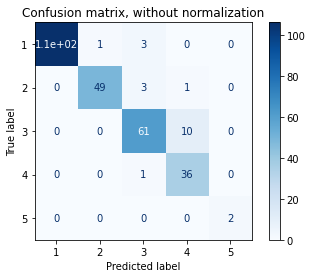

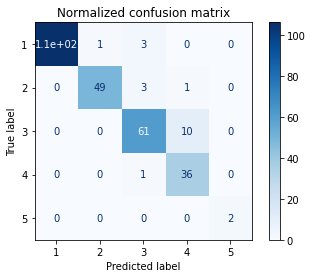

In [254]:
# Define a Decision Tree classifier
dt_clf = DecisionTreeClassifier(min_impurity_decrease=0.02, class_weight='balanced') 

# Create classifier
y_pred = createClassifier(dt_clf, x_train, y_train, x_test, y_test)

# Plot Confusion Matrix
plotConfusionMatrix(dt_clf, x_test, y_test, y_pred, labels)

Principal Component Analysis (PCA)

In [258]:
# Dimensionality reduction using truncated SVD
not_sparse_tfidf = TruncatedSVD(n_components=2, n_iter=7).fit_transform(tfidf)

# Principal component analysis
pca_tfidf = PCA(n_components=2).fit_transform(not_sparse_tfidf)  

# Plot Figure
fig = plotFigure(pca_tfidf, corpus_papers['label'])
print('Principal Component Analysis (PCA)')
fig.show()

Principal Component Analysis (PCA)


Multidimensional scaling (MDS)

In [262]:
# Multidimensional scaling (respect well the distances)
mds_tfidf = MDS(n_components=2).fit_transform(tfidf.toarray())

# Plot Figure
fig = plotFigure(mds_tfidf, corpus_papers['label'])
print('Multidimensional scaling (MDS)')
fig.show()

Multidimensional scaling (MDS)
